In [522]:
using Plots
using StatsBase
include("chebyshev_Q.jl")

Main.chebyshev_Q

# Test Q_discrete


In [523]:
Q = chebyshev_Q.init_Q_discrete([0.0],[1.0],6,2,["nothing", "anything"] )

Main.chebyshev_Q.Q_discrete([1, 2], ["nothing", "anything"], Any[Main.chebyshev_Q.OLS_chebyshev.polynomial(1, [0.0], [1.0], 6, Any[0, 1, 2, 3, 4, 5, 6], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), Main.chebyshev_Q.OLS_chebyshev.polynomial(1, [0.0], [1.0], 6, Any[0, 1, 2, 3, 4, 5, 6], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])], Main.chebyshev_Q.evaluate_Q_discrete, Main.chebyshev_Q.argmax_A_discrete, Main.chebyshev_Q.max_A_discrete)

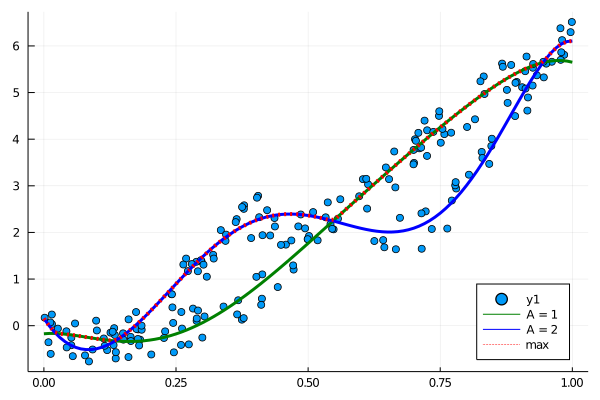

In [548]:
N = 200
a = StatsBase.sample([1,2],N)
s = rand(N)

# simualted data
g(s,a) = sin(5*(a*s-0.5)).+5 .*s^2
Q_ = g.(s,a).+ rand(N) 
Plots.scatter(s,Q_)

chebyshev_Q.update_Q_discrete!(Q,a,s,Q_)

x = 0:0.01:1
y1 = broadcast(x -> chebyshev_Q.evaluate_Q_discrete(Q,x,1)[1], x)
y2 = broadcast(x -> chebyshev_Q.evaluate_Q_discrete(Q,x,2)[1], x)
y_max = broadcast(x -> Q.max_(Q,x)[1],x)
Plots.plot!(x,y1, width = 3, color = "green", label = "A = 1")
Plots.plot!(x,y2, width = 3, color = "blue", label = "A = 2")
Plots.plot!(x,y_max, width = 4, color = "red", linestyle = :dot, legend =:bottomright, label = "max")


# Test Q_continuous 

# Test Q_mixed

# Q_data 

In [413]:
include("Q_data.jl")
using Distributions

In [422]:
q_data = Q_data.init_Q_data(100, 0.9, 2, 1)

Main.Q_data.data(1020, 1, [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], [0.0; 0.0; … ; 0.0; 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

891 891 

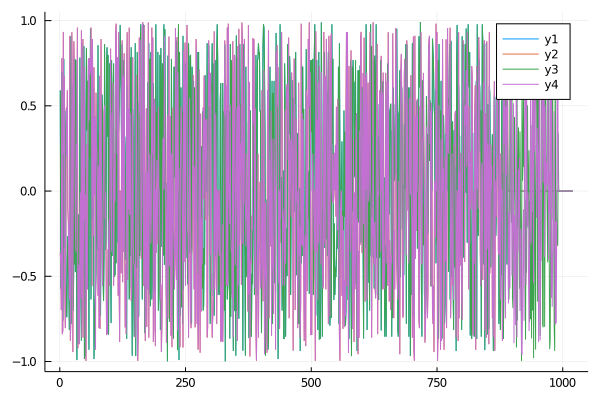

In [763]:
s = rand(Distributions.Uniform(-1,1),100,2)
a = rand((0,1), 100)
Q_ = rand(Distributions.Uniform(0,1), 100)
Q_data.sample_data!(q_data, 0.9)
Plots.plot(q_data.s)
Q_data.add_data!(q_data, Q_, s, a)
Plots.plot!(q_data.s)
#print(sum(q_data.a .== 0))


# Test forward_bellman

In [780]:
include("../POMP/particle_filter.jl")
include("aprox_POMDP.jl")
include("../examples/linear_quadratic.jl")
include("chebyshev_Q.jl")
function T!(x,c)
    return linear_quadratic.T!(x,c,linear_quadratic.pars1d)[1], -x[1]^2 - abs(c)
end
function G(x,y,c)
    return linear_quadratic.G(x,y,c,linear_quadratic.pars1d)
end
function simulate_y(x,a)
    return linear_quadratic.simulate_y(x,linear_quadratic.pars1d)[1]
end

# togle N to see resutls for differnt levels of precision 
N = 200
x0, P0 = [0], [0.5]
prior = Distributions.MvNormal(x0, P0)
samples = rand(prior,N)

samples_ = [samples[:,1]]
for i in 2:N 
    push!(samples_, samples[:,i])
    #samples_ = vcat(samples_, [samples[:,i]]) 
end 
samples = samples_

weights = repeat([log(1.0/N)],N)
POMP_ = particle_filter.POMP(samples,weights,N,G,simulate_y,T!)


function stat(POMP)
    samples, weights = POMP.samples, POMP.weights
    mu = sum(broadcast(i->samples[i][1]*exp(weights[i]), 1:POMP.N))
    sigma = sqrt(sum(broadcast(i-> exp(weights[i])*(samples[i][1] -mu)^2, 1:POMP.N)))
    return [mu,sigma]
end 

function init_x(POMP)
    return particle_filter.sample_x(POMP,1)
end 



data = Q_data.init_Q_data(100, 0.9, 1, 1)
Q_ = chebyshev_Q.init_Q_discrete([-10,-2],[10,2],10,21,collect(-10:10))
print(" ")

In [781]:
POMDP_ = aprox_POMDP.POMDP(POMP_, particle_filter.simulated_joint_dynamics,stat,
                            particle_filter.init_samples!,
                            init_x,data, Q_, 0.9)

print(" ")

In [782]:
POMDP_.Q.evaluate(POMDP_.Q,[[0.1,0.5]],1 )

[[0.010000000000000009, 0.25]]

LoadError: [91mMethodError: no method matching isless(::Float64, ::Array{Float64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  isless(::Float64, [91m::Float64[39m) at float.jl:465[39m
[91m[0m  isless([91m::Missing[39m, ::Any) at missing.jl:87[39m
[91m[0m  isless(::AbstractFloat, [91m::AbstractFloat[39m) at operators.jl:165[39m
[91m[0m  ...[39m

In [772]:
aprox_POMDP.forward_bellman_sample([0.0,0.1],11,POMDP_, 200, 5, 3)

 0 0

LoadError: [91mDomainError with 1.131408076324516:[39m
[91macos(x) not defined for |x| > 1[39m

In [740]:
POMDP_.POMP.N


200